In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train = pd.read_csv('titanic/train.csv')
test  = pd.read_csv('titanic/test.csv')
gender_submission   = pd.read_csv('titanic/gender_submission.csv')

In [3]:


from sklearn.model_selection import train_test_split
train["age_estimated"] = (train["Age"] % 1 == 0.5).astype(int)
test["age_estimated"] = (test["Age"] % 1 == 0.5).astype(int)

train = train.replace({"Sex" : {
    "male" : 0,
    "female" : 1
}})
test = test.replace({"Sex" : {
    "male" : 0,
    "female" : 1
}})

print(train.isnull().sum())
train["Age"] = train["Age"].fillna(train["Age"].median())
test["Age"] = test["Age"].fillna(test["Age"].median())

X = train[["Pclass", "Sex", "Age", "Parch", "age_estimated"]]
y = train[["Survived"]]

test_data = test[["Pclass", "Sex", "Age", "Parch", "age_estimated"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train.describe()



PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              177
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            687
Embarked           2
age_estimated      0
dtype: int64


/tmp/ipykernel_57255/1340828980.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train = train.replace({"Sex" : {
/tmp/ipykernel_57255/1340828980.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test = test.replace({"Sex" : {


,Pclass,Sex,Age,Parch,age_estimated
count,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.330056,0.344101,29.204129,0.379213,0.019663
std,0.824584,0.475408,13.007971,0.791669,0.138937
min,1.000000,0.000000,0.420000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,0.000000,0.000000
max,3.000000,1.000000,80.000000,6.000000,1.000000


In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [5]:
class simpleModel(nn.Module):
    def __init__(self):
        super(simpleModel, self).__init__()
        self.fc1 = nn.Linear(5,1)
        #self.fc2 = nn.Linear(512,512)
        #self.fc3 = nn.Linear(512,1)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        #x = F.relu(self.fc2(x))
        #x = self.drop(x)
        #x = self.fc3(x)
        return x
model = simpleModel().to(device)
print(model)

simpleModel(
  (fc1): Linear(in_features=5, out_features=1, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


In [6]:
X_train = torch.tensor(X_train.tolist())
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train.to_numpy())
y_test = torch.tensor(y_test.to_numpy())
#test_data = torch.tensor(test_data.to_numpy())

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

#changed to batch size 1 for surprise testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [7]:
len(train_dataset)

712

In [8]:
criterion = nn.BCELoss()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
def test_accuracy():
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return f"Accuracy on test data: {100 * correct / total:.2f}%"

In [ ]:
#batch_size = 32
#n_epochs = 5000
#batch_no = len(X_train) // batch_size
#losses = []
#surprise_values = []
#
#with torch.autograd.set_detect_anomaly(True):
#
#    train_loss = 0
#    train_loss_min = np.inf
#
#    surprise_decay = 0.9
#    
#
#    for epoch in range(n_epochs):
#        
#        for inputs, labels in train_loader:
#            
#            inputs, labels = inputs.to(device), labels.to(device)
#            inputs.requires_grad = True
#
#            optimizer.zero_grad()
#            out = torch.clamp(torch.sigmoid(model(inputs)), 1e-7, 1 - 1e-7)
#            loss = criterion(out, labels.float())
#            loss.backward()
#            optimizer.step()
#
#            
#            #labels = torch.max(out)
#            num_right = np.sum(labels.data.cpu().numpy() == out.detach().cpu().numpy())
#            
#            train_loss += loss.item()
#            losses.append(loss.item())
#
#            surprise = torch.sum(torch.abs(inputs.grad)) // 5#.item()
#            if len(surprise_values) > 0:
#                surprise = surprise_decay * surprise_values[-1] + (1 - surprise_decay) * surprise
#
#            surprise_values.append(surprise)
#
#            
#
#        train_loss = train_loss / len(X_train)
#
#        if epoch % 200 == 0:
#            
#            print('')
#            print("Epoch: {} \tTrain Loss: {} ".format(epoch+1, train_loss ) + test_accuracy())
#
#xpoints = np.arange(len(losses))
#losses = np.asarray(losses)
#surprises = np.asarray(torch.stack(surprise_values).detach().cpu())
#plt.plot(xpoints, losses)
#
#plt.show()
#plt.plot(xpoints, surprises)
#plt.show()

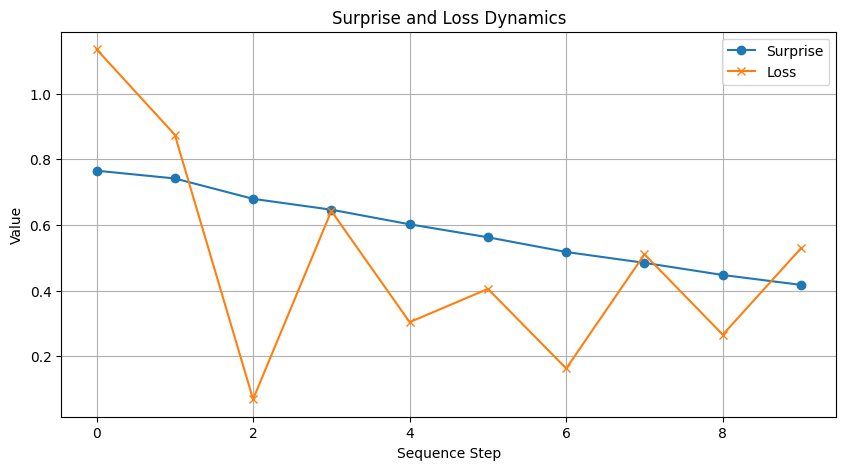

In [7]:
# Sample input data (e.g., 10 tokens, 1 feature)
input_seq = torch.randn(10, 1)

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)
    def forward(self, x):
        return self.linear(x)

# Instantiate the model and optimizer
model = SimpleModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Lists to track the surprise and loss for visualization
surprise_values = []
loss_values = []

# Simplified surprise mechanism with decay
surprise_decay = 0.9  # How fast surprise decays over time
for i in range(len(input_seq)):
    input_token = input_seq[i]
    input_token.requires_grad = True  # Track gradient for input

    # Make a prediction
    output = model(input_token)

    # Sample Loss
    loss = (output - input_token) ** 2  # Example loss

    # Backpropagate to calculate gradients
    optimizer.zero_grad()
    loss.backward()

    # Calculate and decay surprise
    surprise = torch.abs(input_token.grad).item()
    if i > 0:
        surprise = surprise_decay * surprise_values[-1] + (1 - surprise_decay) * surprise

    # Track loss and surprise
    surprise_values.append(surprise)
    loss_values.append(loss.item())

    # Update model weights based on "surprise" (gradient magnitude)
    with torch.no_grad():
        model.linear.weight -= 0.1 * input_token.grad

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(surprise_values, label='Surprise', marker='o')
plt.plot(loss_values, label='Loss', marker='x')
plt.xlabel('Sequence Step')
plt.ylabel('Value')
plt.title('Surprise and Loss Dynamics')
plt.legend()
plt.grid()
plt.show()

In [22]:
def test__titan_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            outputs, _ = model(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy on test data: {100 * correct / total:.2f}%")

Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.10%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 57.54%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy on test data: 58.66%
Accuracy o

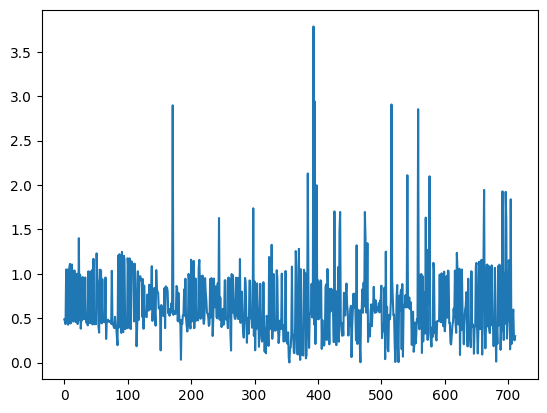

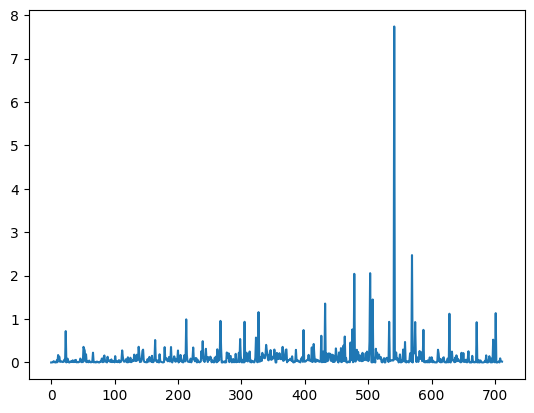

In [23]:
criterion = nn.BCELoss()

class LongTermMemory(nn.Module):
    def __init__(self, memory_size=10, feature_size=5):
        super().__init__()
        self.memory = nn.Parameter(torch.zeros(memory_size, feature_size))
        self.memory_size = memory_size
        self.feature_size = feature_size
        self.W_query = nn.Linear(feature_size, feature_size)
        self.W_key = nn.Linear(feature_size, feature_size)
        self.W_value = nn.Linear(feature_size, feature_size)

    def forward(self, x):
        query = self.W_query(x)
        keys = self.W_key(self.memory)
        values = self.W_value(self.memory)

        attention_scores = torch.softmax(torch.matmul(query, keys.T), dim=-1)
        retrieved_memory = torch.matmul(attention_scores, values)
        return retrieved_memory, attention_scores
    
    def update_memory(self, x, surprise, forget_rate=0.1):
        self.memory.data *= (1- forget_rate)

        with torch.no_grad():
            insertion_index = int(surprise) % self.memory_size
            self.memory.data[insertion_index] = x


class TitanModel(nn.Module):
    def __init__(self, memory_size=10, feature_size=5):
        super().__init__()
        self.memory_module = LongTermMemory(memory_size, feature_size)
        self.output_layer = nn.Linear(feature_size, 1)

    def forward(self, x):
        retrieved_memory, attention_scores = self.memory_module(x)
        output = self.output_layer(retrieved_memory)
        return output, attention_scores
    
model = TitanModel(memory_size=5, feature_size=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []
surprise_values = []

for inputs, labels in train_loader:
    
    inputs, labels = inputs.to(device), labels.to(device)
    inputs.requires_grad = True

    output, attention_scores = model(inputs)
    output = torch.clamp(torch.sigmoid(output), 1e-7, 1 - 1e-7)
    loss = criterion(output, labels.float())

    optimizer.zero_grad()
    loss.backward()

    surprise = torch.sum(torch.abs(inputs.grad)).item()
    surprise_values.append(surprise)

    model.memory_module.update_memory(inputs.detach(), surprise)

    optimizer.step()

    losses.append(loss.item())

    test__titan_accuracy(model)

xpoints = np.arange(len(losses))
losses = np.asarray(losses)
surprises = np.asarray(surprise_values)
plt.plot(xpoints, losses)

plt.show()
plt.plot(xpoints, surprises)
plt.show()
